# Dataset

In [1]:
import numpy as np
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
# Load the data

from google.colab import drive
drive.mount('/content/drive')
X_test = np.load("drive/MyDrive/Junior Year/ECE C147/data/X_test.npy")
y_test = np.load("drive/MyDrive/Junior Year/ECE C147/data/y_test.npy")
person_train_valid = np.load("drive/MyDrive/Junior Year/ECE C147/data/person_train_valid.npy")
X_train_valid = np.load("drive/MyDrive/Junior Year/ECE C147/data/X_train_valid.npy")
y_train_valid = np.load("drive/MyDrive/Junior Year/ECE C147/data/y_train_valid.npy")
person_test = np.load("drive/MyDrive/Junior Year/ECE C147/data/person_test.npy")


Mounted at /content/drive


## Shape of Data

In [ ]:
print("Training/Valid data shape: ", X_train_valid.shape)
print("Test data shape: ", X_test.shape)
print("Training/Valid target shape: ", y_train_valid.shape)
print("Test target shape: ", y_test.shape)
print("Person train/valid shape: ", person_train_valid.shape)
print('Person test shape: ', person_test.shape)


Training/Valid data shape:  (2115, 22, 1000)
Test data shape:  (443, 22, 1000)
Training/Valid target shape:  (2115,)
Test target shape:  (443,)
Person train/valid shape:  (2115, 1)
Person test shape:  (443, 1)


## Data Preparation

In [2]:
def loaddata(subidx = None, time = 500):
    X_test = np.load("drive/MyDrive/Junior Year/ECE C147/data/X_test.npy")
    y_test = np.load("drive/MyDrive/Junior Year/ECE C147/data/y_test.npy")
    person_train_valid = np.load("drive/MyDrive/Junior Year/ECE C147/data/person_train_valid.npy")
    X_train_valid = np.load("drive/MyDrive/Junior Year/ECE C147/data/X_train_valid.npy")
    y_train_valid = np.load("drive/MyDrive/Junior Year/ECE C147/data/y_train_valid.npy")
    person_test = np.load("drive/MyDrive/Junior Year/ECE C147/data/person_test.npy")

    #Adjust labels to start from 0
    y_train_valid -= 769
    y_test -= 769

    # Only include time points from 0 to time
    X_train_valid = X_train_valid[:, :, :time]
    X_test = X_test[:, :, :time]

    # Split into train and validation
    # First generating the training and validation indices using random splitting, 80/20 split for training and validation
    if subidx is not None:
        ind = np.where(person_train_valid == subidx)[0]
        ind_valid = np.random.choice(len(ind), int(len(ind) * 0.2), replace=False)
        ind_train = np.array(list(set(range(len(ind))).difference(set(ind[ind_valid]))))
    else:
        ind_valid = np.random.choice(2115, 423, replace=False)
        ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

    # Creating the training and validation sets using the generated indices
    (x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
    (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test, 4)

    if subidx is not None:
      ind = np.where(person_test == subidx)[0]
      X_test = X_test[ind]
      y_test = y_test[ind]

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    print('Shape of training set after dimension reshaping:',x_train.shape)
    print('Shape of validation set after dimension reshaping:',x_valid.shape)
    print('Shape of test set after dimension reshaping:',x_test.shape)


    return x_train, y_train, x_valid, y_valid, x_test, y_test


In [19]:
x_train, y_train, x_valid, y_valid, x_test, y_test = loaddata(subidx = 5,time = 50)

Shape of training set after dimension reshaping: (236, 50, 1, 22)
Shape of validation set after dimension reshaping: (47, 50, 1, 22)
Shape of test set after dimension reshaping: (49, 50, 1, 22)


# Training Model: Parameters and Fitting

In [4]:

def cnnmodeltest(filters_list, kernel_size, pool_size, activation, dropout_rate, time = 500):
    model = Sequential()

    for i in range(len(filters_list)):
        # Convolutional block
        model.add(Conv2D(filters=filters_list[i], kernel_size = kernel_size, padding='same', activation=activation, input_shape=(time, 1, 22)))
        model.add(MaxPooling2D(pool_size=pool_size, padding='same'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Output layer with Softmax activation
    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))

    # Printing the model summary
    model.summary()

    return model


In [5]:
def trainmodel(model, x_train, y_train, x_valid, y_valid, learning_rate = 1e-3, epochs = 100, batch_size = 64):
    '''
    Compile and train model with specified hyperparameters
    '''
    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

    #callbacks for checkpoint and earlystopping
    checkpoint = ModelCheckpoint(filepath = 'checkpoints/cnnmodel_checkpoint.h5', save_best_only=True)
    early_stopping = EarlyStopping(monitor='loss', patience=5, mode='min', verbose=1)

    #Train and validate model
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks = [checkpoint, early_stopping],
                        validation_data=(x_valid, y_valid), verbose = True)
    return history

In [6]:
def evaluatemodel(model, results, x_test, y_test, subidx = None):
  cnn_score = model.evaluate(x_test, y_test, verbose = 0)

  plt.plot(results.history['accuracy'])
  plt.plot(results.history['val_accuracy'])
  if subidx is not None:
    plt.title('CNN Model Accuracy Trajectory for Subject ' + str(subidx+1))
  else:
    plt.title('CNN Model Accuracy Trajectory')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  # Plotting loss trajectory
  plt.plot(results.history['loss'],'o')
  plt.plot(results.history['val_loss'],'o')
  if subidx is not None:
    plt.title('Basic CNN model loss trajectory for Subject ' + str(subidx+1))
  else:
    plt.title('Basic CNN model loss trajectory')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  print('Test accuracy of CNN model:',cnn_score[1])
  return cnn_score[1]



# Classification Accuracy for Single Subjects

Function to train model for subject 1

In [10]:
def trainsubject(subidx = 0, time = 500):
    x_train, y_train, x_valid, y_valid, x_test_whole, y_test_whole = loaddata()
    x_train, y_train, x_valid, y_valid, x_test, y_test = loaddata(subidx, time)
    cnnmodel = cnnmodeltest(filters_list, kernel_size, pool_size, activation, dropout_rate)
    print("----------------" + "Training on subject " + str(subidx + 1) + " ----------------")
    results = trainmodel(cnnmodel, x_train, y_train, x_valid, y_valid, learning_rate)

    print('TESTING ACCURACY ON SUBJECT TEST SET')
    evaluatemodel(cnnmodel, results, x_test, y_test, subidx)

    print('TESTING ACCURACY ON ENTIRE TEST SET')
    return evaluatemodel(cnnmodel, results, x_test_whole, y_test_whole, subidx)

    # test on entire test data

    # cnn_score = cnnmodel.evaluate(x_test, y_test, verbose=0)

    # plt.plot(results.history['accuracy'])
    # plt.plot(results.history['val_accuracy'])
    # plt.title('CNN Model Accuracy Trajectory for Subject ' + str(subidx))
    # plt.ylabel('accuracy')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'val'], loc='upper left')
    # plt.show()


    #print('Test accuracy of the CNN model:',cnn_score[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 500, 1, 25)        35225     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 167, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 167, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 167, 1, 25)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 167, 1, 50)        80050     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 1, 50)        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 52ms/step - loss: 1.8662 - accuracy: 0.3911 - val_loss: 1.3925 - val_accuracy: 0.3191
Epoch 4/100
4/4 [==============================] - 0s 62ms/step - loss: 1.8593 - accuracy: 0.4307 - val_loss: 1.3642 - val_accuracy: 0.3617
Epoch 5/100
4/4 [==============================] - 0s 30ms/step - loss: 1.9255 - accuracy: 0.4307 - val_loss: 1.4122 - val_accuracy: 0.3830
Epoch 6/100
4/4 [==============================] - 0s 31ms/step - loss: 1.9317 - accuracy: 0.4307 - val_loss: 1.4665 - val_accuracy: 0.2979
Epoch 7/100
4/4 [==============================] - 0s 33ms/step - loss: 1.7977 - accuracy: 0.4802 - val_loss: 1.4911 - val_accuracy: 0.2766
Epoch 8/100
4/4 [==============================] - 0s 27ms/step - loss: 1.7892 - accuracy: 0.4703 - val_loss: 1.4372 - val_accuracy: 0.3191
Epoch 9/100
4/4 [==============================] - 0s 26ms/step - loss: 1.4681 - accuracy: 0.5297 - val_loss: 1.4619 - val_accuracy: 0.3191
Epoch 10/100
4/4 [==============

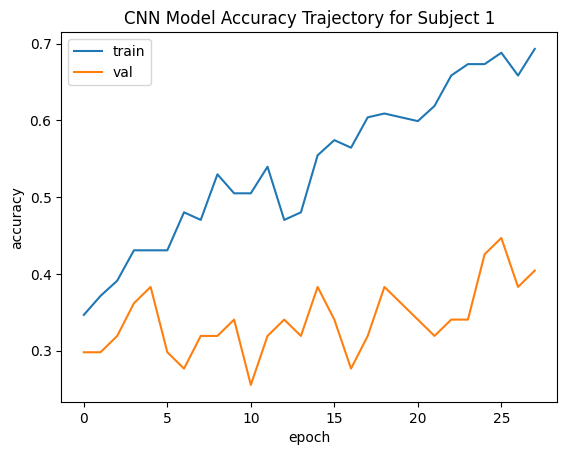

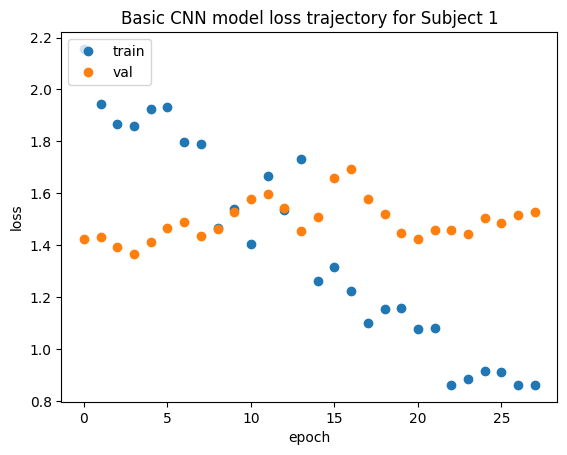

Test accuracy of CNN model: 0.3799999952316284
TESTING ACCURACY ON ENTIRE TEST SET


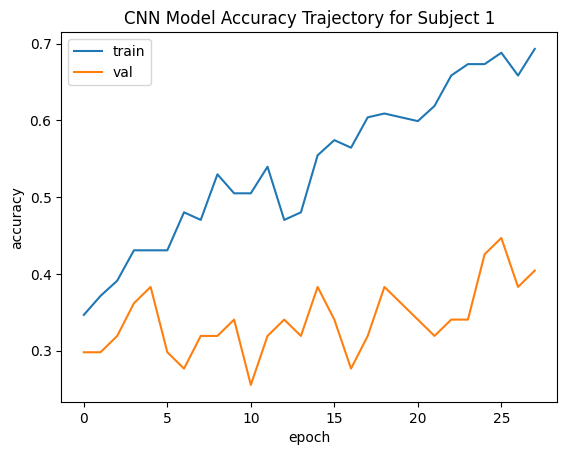

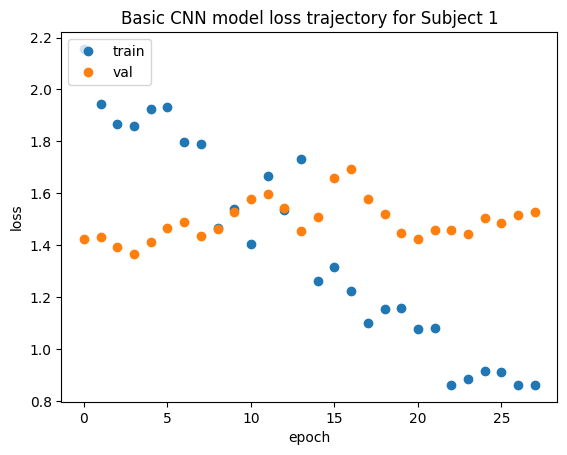

Test accuracy of CNN model: 0.3453724682331085
Shape of training set after dimension reshaping: (1692, 500, 1, 22)
Shape of validation set after dimension reshaping: (423, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)
Shape of training set after dimension reshaping: (224, 500, 1, 22)
Shape of validation set after dimension reshaping: (47, 500, 1, 22)
Shape of test set after dimension reshaping: (50, 500, 1, 22)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 500, 1, 25)        35225     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 167, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_12 (Ba  (None, 167, 1, 25)        100       
 tchNo

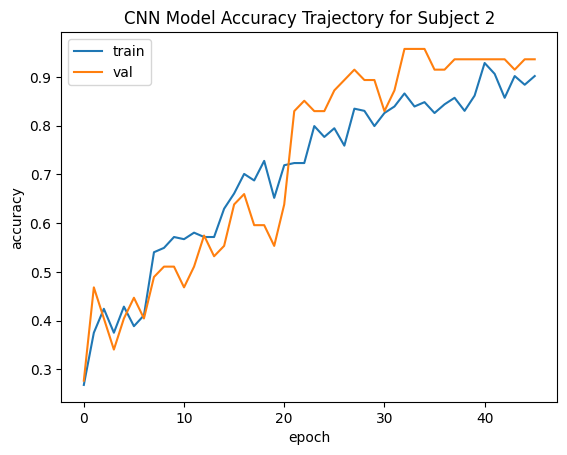

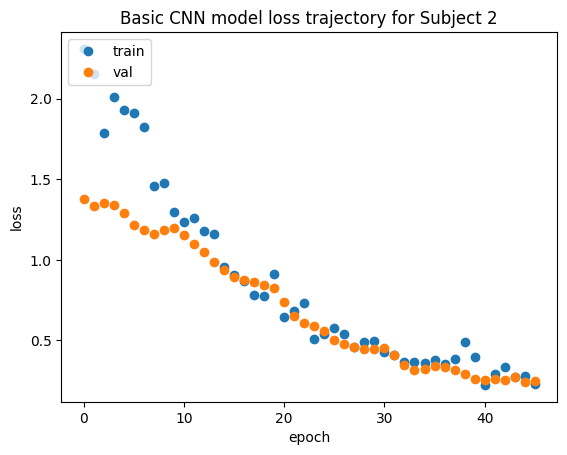

Test accuracy of CNN model: 0.3799999952316284
TESTING ACCURACY ON ENTIRE TEST SET


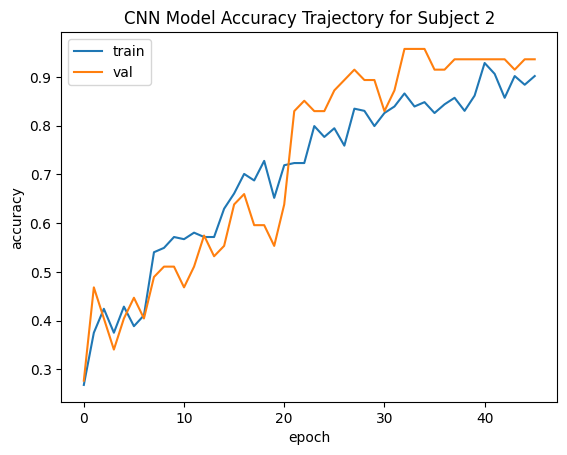

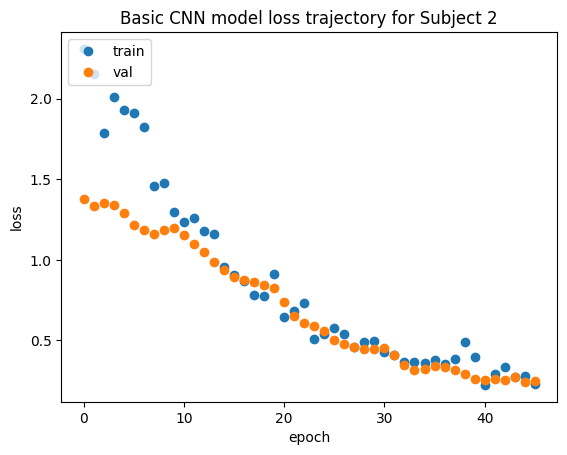

Test accuracy of CNN model: 0.3566591441631317
Shape of training set after dimension reshaping: (1692, 500, 1, 22)
Shape of validation set after dimension reshaping: (423, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)
Shape of training set after dimension reshaping: (236, 500, 1, 22)
Shape of validation set after dimension reshaping: (47, 500, 1, 22)
Shape of test set after dimension reshaping: (50, 500, 1, 22)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 500, 1, 25)        35225     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 167, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_16 (Ba  (None, 167, 1, 25)        100       
 tchNo

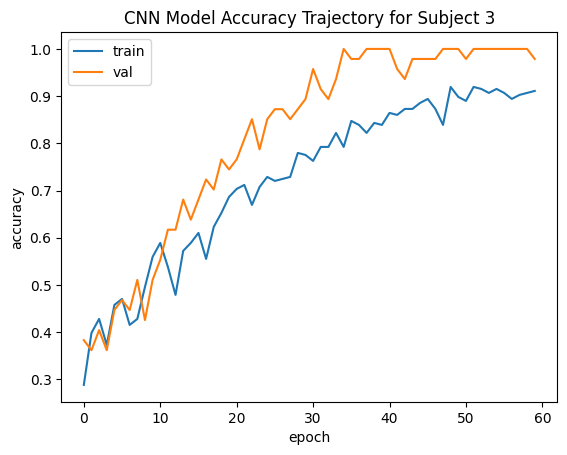

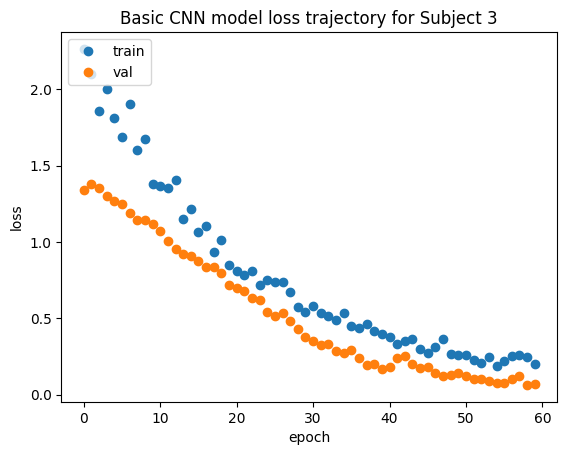

Test accuracy of CNN model: 0.4399999976158142
TESTING ACCURACY ON ENTIRE TEST SET


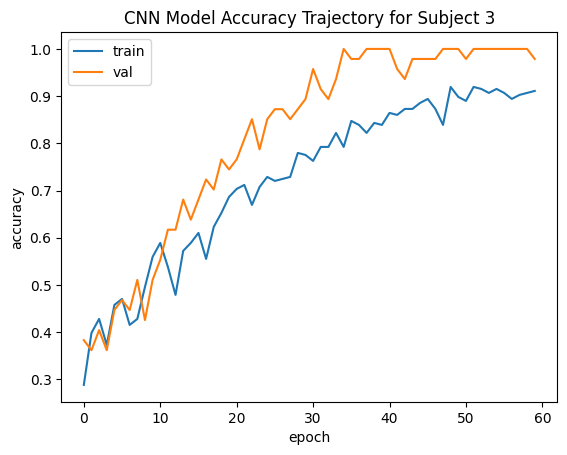

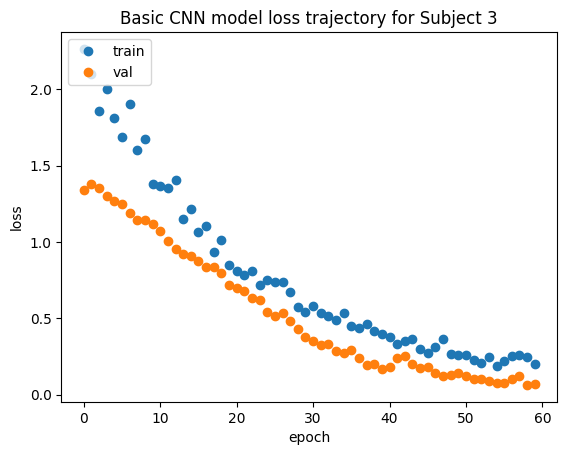

Test accuracy of CNN model: 0.3927765190601349
Shape of training set after dimension reshaping: (1692, 500, 1, 22)
Shape of validation set after dimension reshaping: (423, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)
Shape of training set after dimension reshaping: (234, 500, 1, 22)
Shape of validation set after dimension reshaping: (46, 500, 1, 22)
Shape of test set after dimension reshaping: (50, 500, 1, 22)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 500, 1, 25)        35225     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 167, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 167, 1, 25)        100       
 tchNo

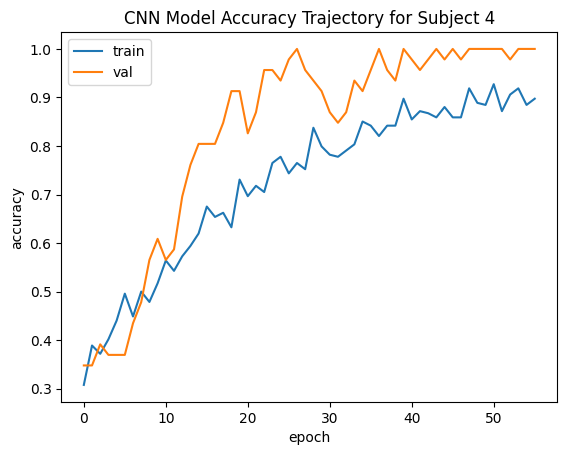

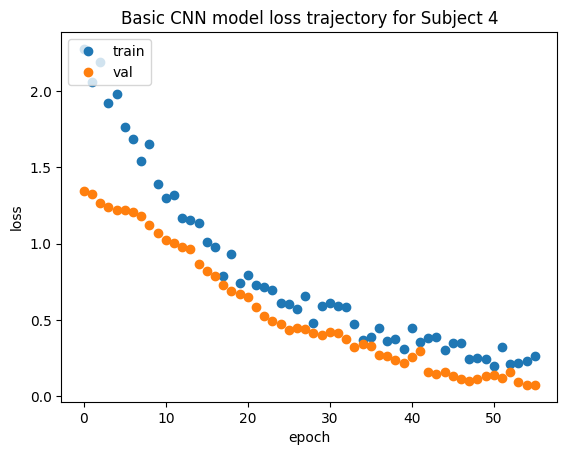

Test accuracy of CNN model: 0.4000000059604645
TESTING ACCURACY ON ENTIRE TEST SET


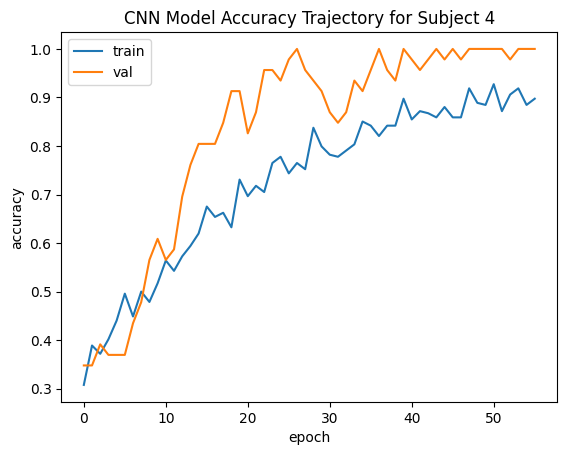

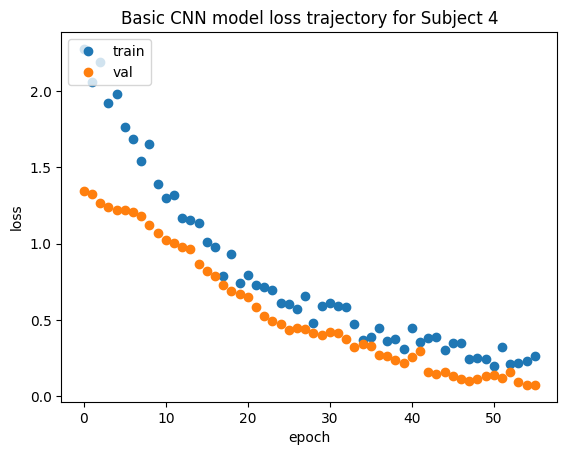

Test accuracy of CNN model: 0.41534990072250366
Shape of training set after dimension reshaping: (1692, 500, 1, 22)
Shape of validation set after dimension reshaping: (423, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)
Shape of training set after dimension reshaping: (235, 500, 1, 22)
Shape of validation set after dimension reshaping: (47, 500, 1, 22)
Shape of test set after dimension reshaping: (47, 500, 1, 22)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 500, 1, 25)        35225     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 167, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_24 (Ba  (None, 167, 1, 25)        100       
 tchN

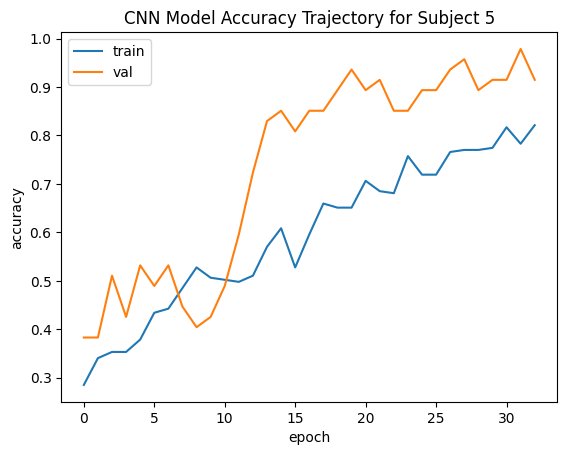

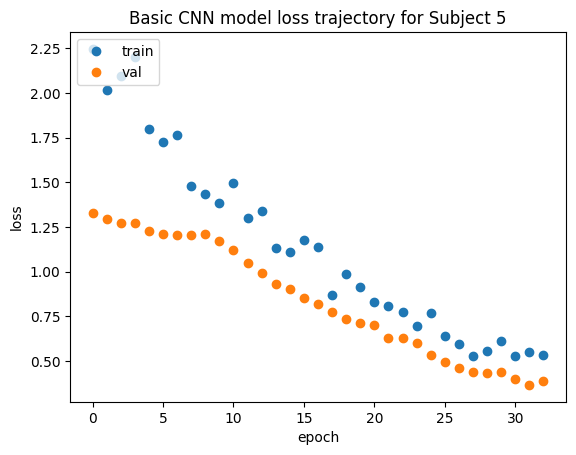

Test accuracy of CNN model: 0.25531914830207825
TESTING ACCURACY ON ENTIRE TEST SET


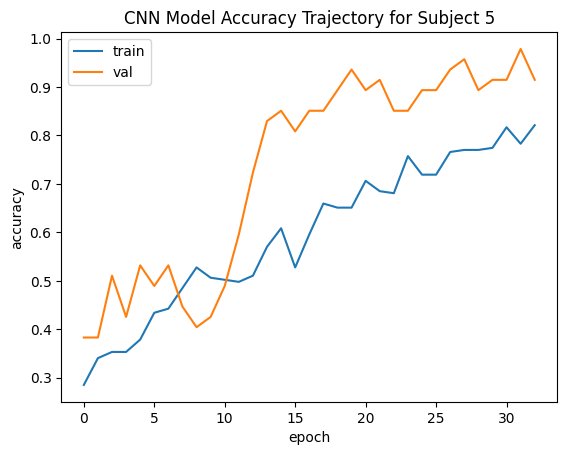

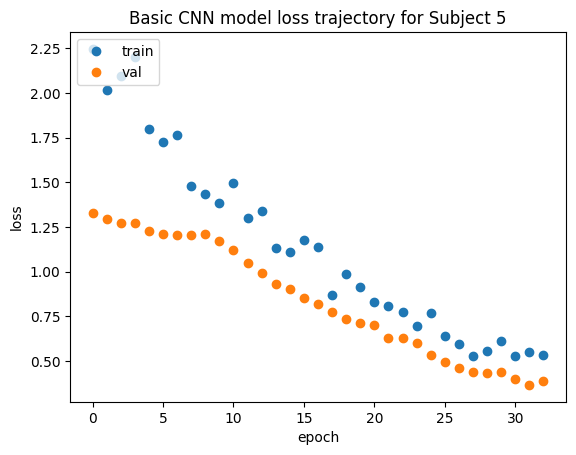

Test accuracy of CNN model: 0.40857788920402527
Shape of training set after dimension reshaping: (1692, 500, 1, 22)
Shape of validation set after dimension reshaping: (423, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)
Shape of training set after dimension reshaping: (236, 500, 1, 22)
Shape of validation set after dimension reshaping: (47, 500, 1, 22)
Shape of test set after dimension reshaping: (49, 500, 1, 22)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 500, 1, 25)        35225     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 167, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_28 (Ba  (None, 167, 1, 25)        100       
 tchN

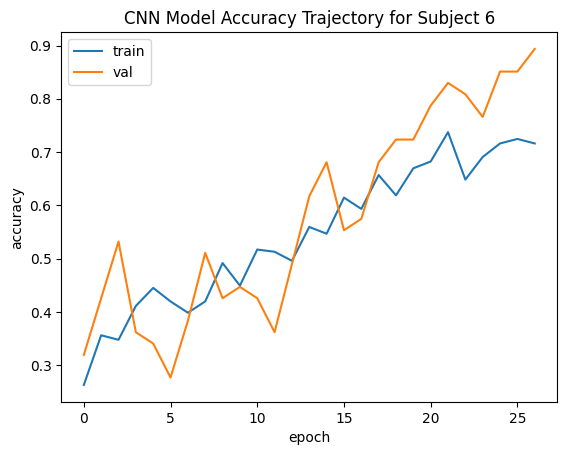

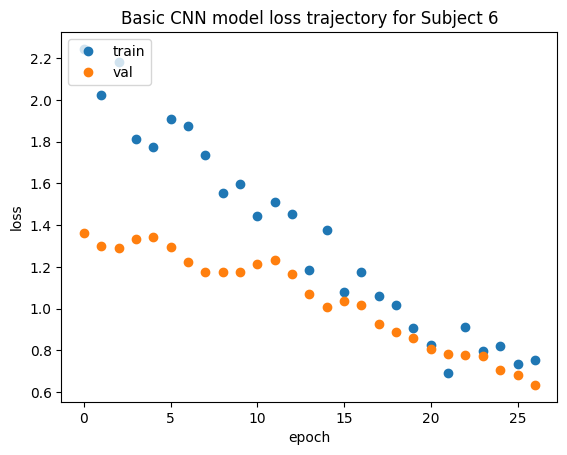

Test accuracy of CNN model: 0.3469387888908386
TESTING ACCURACY ON ENTIRE TEST SET


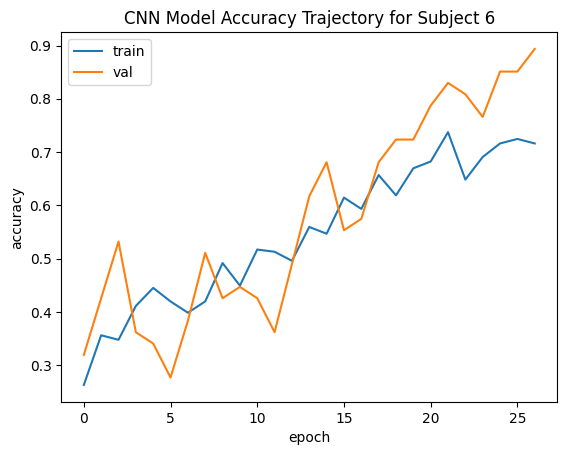

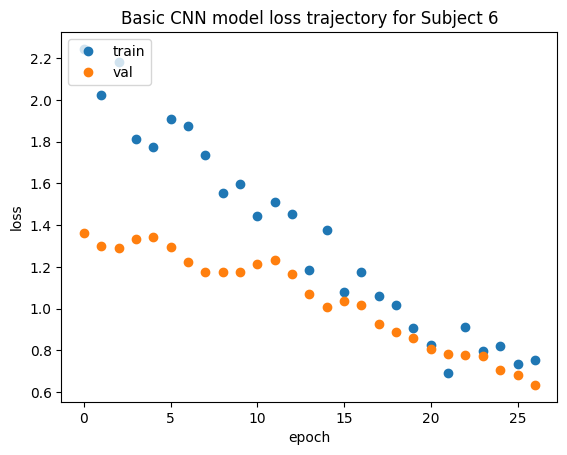

Test accuracy of CNN model: 0.3724604845046997
Shape of training set after dimension reshaping: (1692, 500, 1, 22)
Shape of validation set after dimension reshaping: (423, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)
Shape of training set after dimension reshaping: (238, 500, 1, 22)
Shape of validation set after dimension reshaping: (47, 500, 1, 22)
Shape of test set after dimension reshaping: (50, 500, 1, 22)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 500, 1, 25)        35225     
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 167, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_32 (Ba  (None, 167, 1, 25)        100       
 tchNo

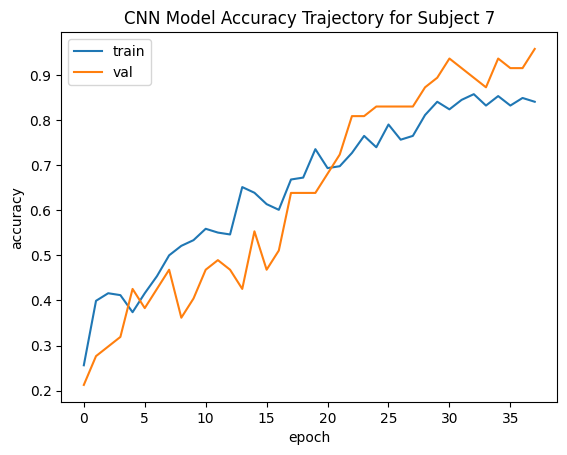

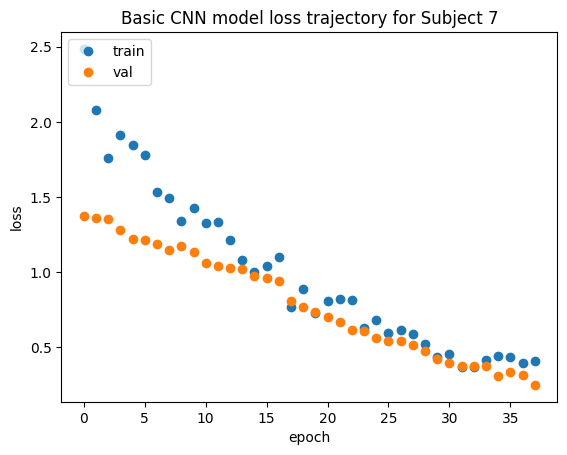

Test accuracy of CNN model: 0.5199999809265137
TESTING ACCURACY ON ENTIRE TEST SET


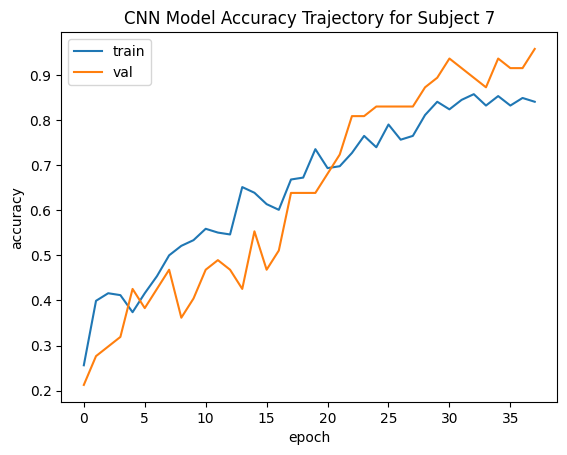

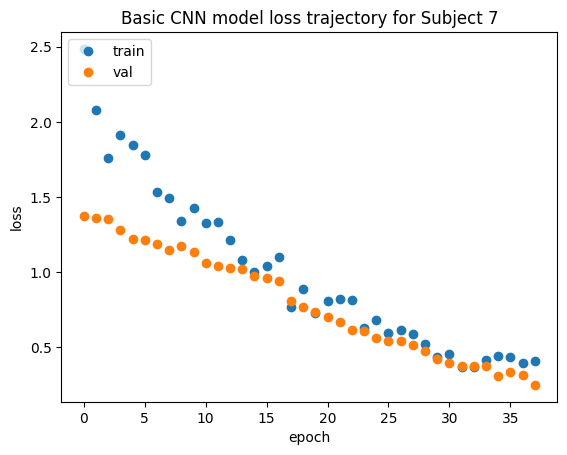

Test accuracy of CNN model: 0.43115124106407166
Shape of training set after dimension reshaping: (1692, 500, 1, 22)
Shape of validation set after dimension reshaping: (423, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)
Shape of training set after dimension reshaping: (232, 500, 1, 22)
Shape of validation set after dimension reshaping: (46, 500, 1, 22)
Shape of test set after dimension reshaping: (50, 500, 1, 22)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 500, 1, 25)        35225     
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 167, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_36 (Ba  (None, 167, 1, 25)        100       
 tchN

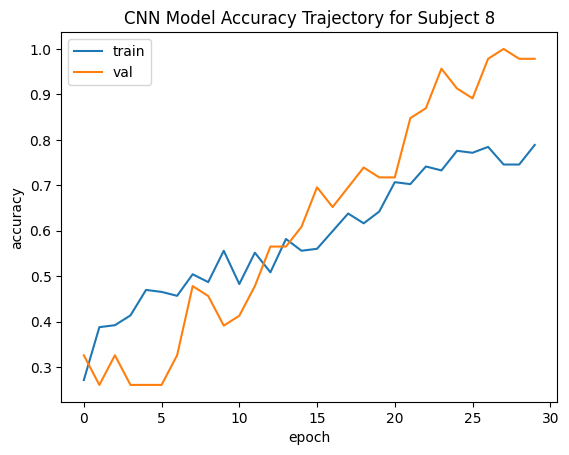

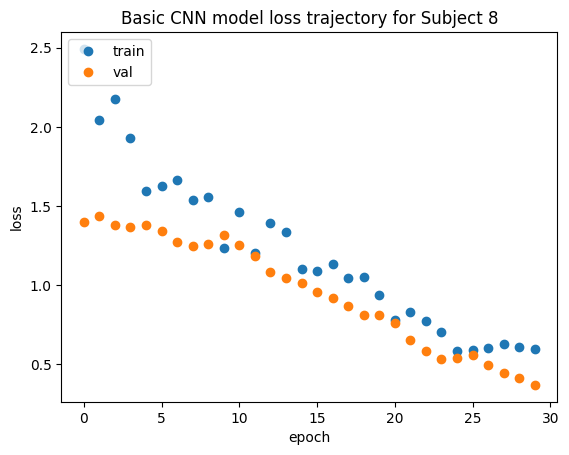

Test accuracy of CNN model: 0.36000001430511475
TESTING ACCURACY ON ENTIRE TEST SET


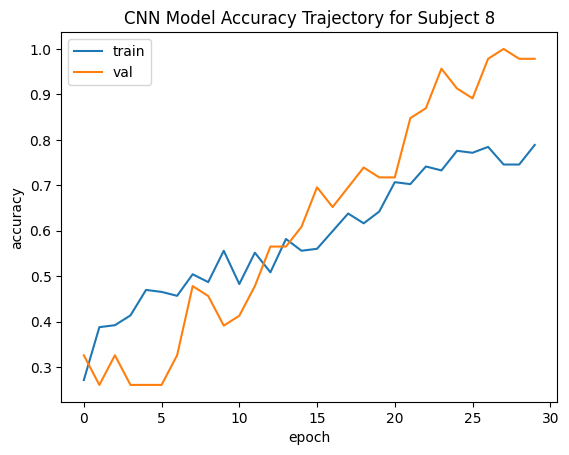

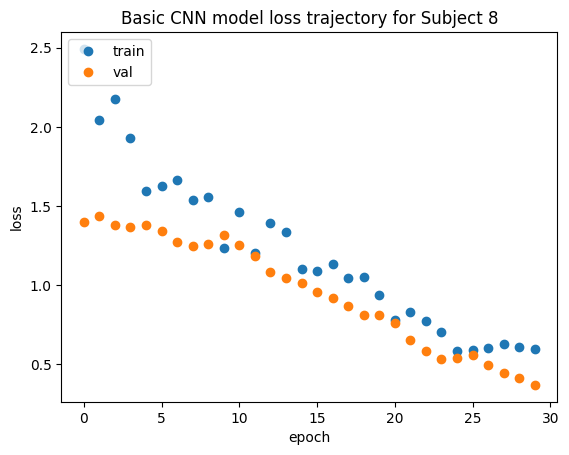

Test accuracy of CNN model: 0.3611738085746765
Shape of training set after dimension reshaping: (1692, 500, 1, 22)
Shape of validation set after dimension reshaping: (423, 500, 1, 22)
Shape of test set after dimension reshaping: (443, 500, 1, 22)
Shape of training set after dimension reshaping: (231, 500, 1, 22)
Shape of validation set after dimension reshaping: (46, 500, 1, 22)
Shape of test set after dimension reshaping: (47, 500, 1, 22)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 500, 1, 25)        35225     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 167, 1, 25)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_40 (Ba  (None, 167, 1, 25)        100       
 tchN

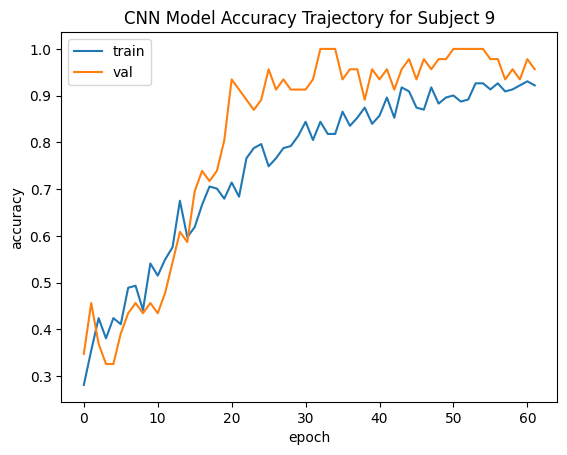

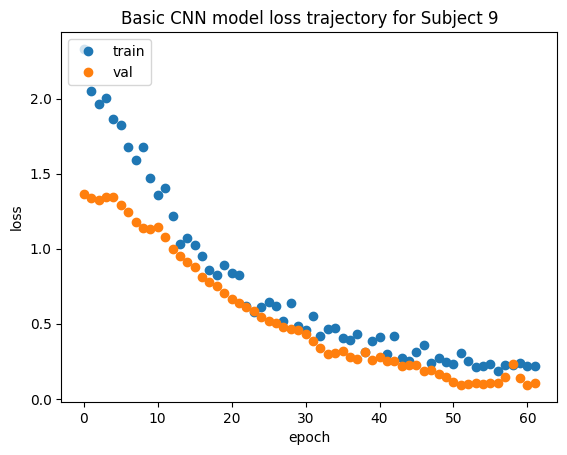

Test accuracy of CNN model: 0.3617021143436432
TESTING ACCURACY ON ENTIRE TEST SET


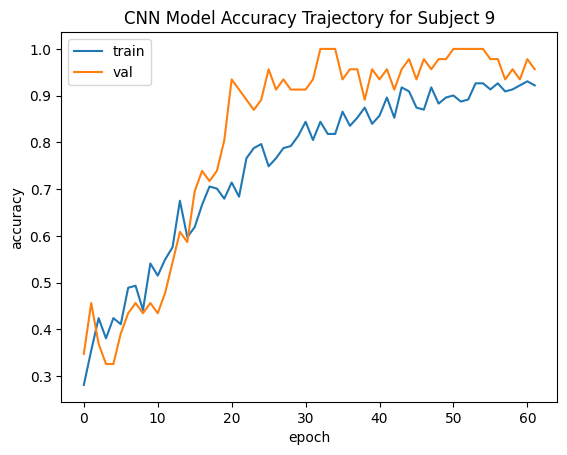

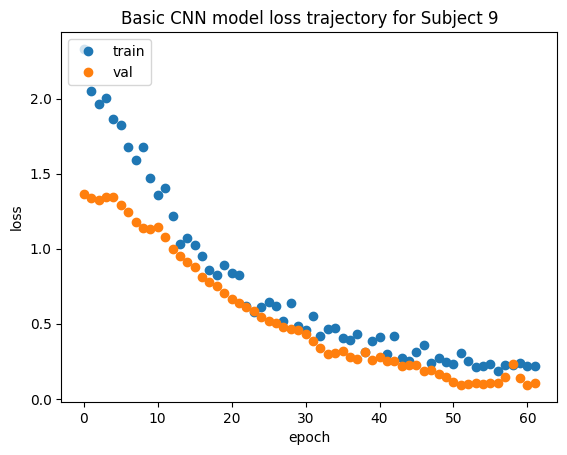

Test accuracy of CNN model: 0.3905192017555237
Best Testing Score


In [11]:
# TESTING PARAMETERS
# kernel: 3,3 pool: 2,1, act: relu, dropout: 0.2 <- bad, relu, small dropout kernel and pool cause overfitting
# DROPOUT: 0.7 <-
filters_list = [25, 50, 100, 200]
kernel_size = (8,8)
pool_size = (3,1)
activation = 'elu'
dropout_rate = 0.5
learning_rate = 1e-3
epochs = 100
batch_size = 64

# Test the model with different hyperparameters
cnnmodel = cnnmodeltest(filters_list, kernel_size, pool_size, activation, dropout_rate)

#Train on each individual subject
test_scores = {}
for i in range(9):
  result = trainsubject(i)
  test_scores[i+1] = result

print('Best Testing Score')

In [12]:
# Initialize variables to track the best score and its index
best_score = max(test_scores.values())
best_index = max(test_scores, key=test_scores.get)

print('Best Testing Score:', best_score)
print('Index for Best Testing Score:', best_index)


Best Testing Score: 0.43115124106407166
Index for Best Testing Score: 7


# Classification Accuracy Across All Subjects

In [ ]:
# TESTING PARAMETERS
# kernel: 3,3 pool: 2,1, act: relu, dropout: 0.2 <- bad, relu, small dropout kernel and pool cause overfitting
# DROPOUT: 0.7 <-
filters_list = [25, 50, 100, 200]
kernel_size = (8,8)
pool_size = (3,1)
activation = 'elu'
dropout_rate = 0.5
learning_rate = 1e-3
epochs = 100
batch_size = 64

# Test the model with different hyperparameters
cnnmodel = cnnmodeltest(filters_list, kernel_size, pool_size, activation, dropout_rate)

results = trainmodel(cnnmodel, x_train, y_train, x_valid, y_valid)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 500, 1, 25)        35225     
                                                                 
 max_pooling2d (MaxPooling2  (None, 167, 1, 25)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 167, 1, 25)        100       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 167, 1, 25)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 167, 1, 50)        80050     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 1, 50)         0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 21ms/step - loss: 2.0177 - accuracy: 0.3463 - val_loss: 1.3006 - val_accuracy: 0.3853
Epoch 3/100
27/27 [==============================] - 1s 21ms/step - loss: 1.7440 - accuracy: 0.3907 - val_loss: 1.2919 - val_accuracy: 0.3570
Epoch 4/100
27/27 [==============================] - 1s 24ms/step - loss: 1.6236 - accuracy: 0.3960 - val_loss: 1.2170 - val_accuracy: 0.4374
Epoch 5/100
27/27 [==============================] - 1s 20ms/step - loss: 1.5263 - accuracy: 0.4255 - val_loss: 1.2212 - val_accuracy: 0.4303
Epoch 6/100
27/27 [==============================] - 1s 25ms/step - loss: 1.4286 - accuracy: 0.4468 - val_loss: 1.2074 - val_accuracy: 0.4232
Epoch 7/100
27/27 [==============================] - 1s 24ms/step - loss: 1.3555 - accuracy: 0.4486 - val_loss: 1.0925 - val_accuracy: 0.5248
Epoch 8/100
27/27 [==============================] - 1s 20ms/step - loss: 1.2639 - accuracy: 0.4976 - val_loss: 1.1858 - val_accuracy: 0.4775
Epoch 9/100
27/27 

# Accuracy Results

Plot Accuracy and loss curves

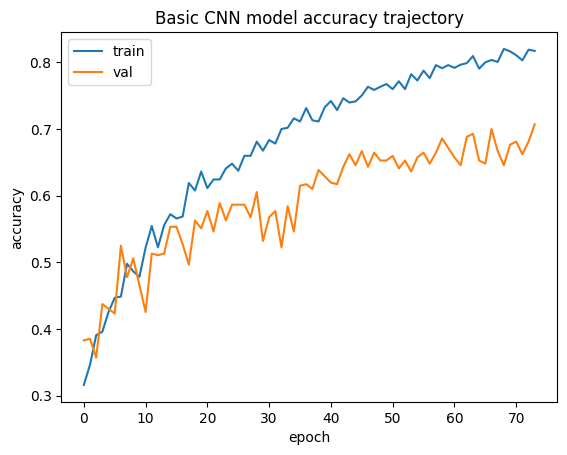

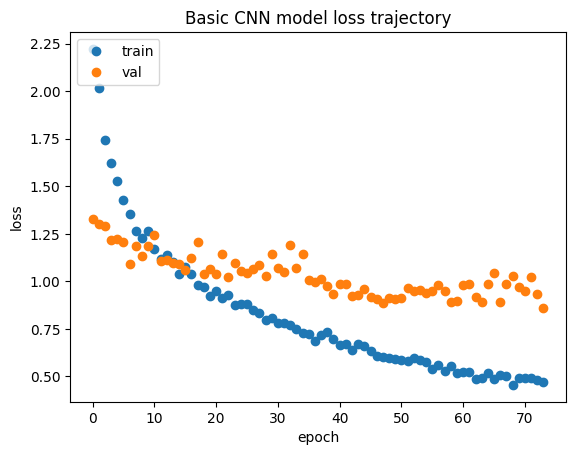

In [ ]:
# Plotting accuracy trajectory
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(results.history['loss'],'o')
plt.plot(results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing Accuracy

In [ ]:
cnn_score = cnnmodel.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.7065462470054626


# Classification Accuracy Over Time
We can make a function to train the model for different time periods, from 0:50 to 0:1000.

In [ ]:
def trainovertime():
  # loop for different times
  train_scores = []
  val_scores = []
  test_scores = []
  for time in range(50,1001, 50):
    print("----------------" + str(time) + "----------------")
    x_train, y_train, x_valid, y_valid, x_test, y_test = loaddata(time = time)
    cnnmodel = cnnmodeltest(filters_list, kernel_size, pool_size, activation, dropout_rate, time = time)
    results = trainmodel(cnnmodel, x_train, y_train, x_valid, y_valid, learning_rate)
    cnn_score = cnnmodel.evaluate(x_test, y_test, verbose=0)
    test_scores.append(cnn_score[1])

  #plot test scores as function over time
  plt.plot(range(50,1001, 50), test_scores)
  plt.title('Test accuracy over time')
  plt.ylabel('accuracy')
  plt.xlabel('time')
  plt.show()

  #Best Test score and time
  print("Test Accuracies:")
  print(test_scores)
  print('Best test score:', max(test_scores))
  print('Best time:', (test_scores.index(max(test_scores))+1)*50)




----------------50----------------
Shape of training set after dimension reshaping: (1692, 50, 1, 22)
Shape of validation set after dimension reshaping: (423, 50, 1, 22)
Shape of test set after dimension reshaping: (443, 50, 1, 22)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 50, 1, 25)         35225     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 17, 1, 25)         0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 17, 1, 25)         100       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 17, 1, 25)         0         
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 15ms/step - loss: 2.1426 - accuracy: 0.2577 - val_loss: 1.3870 - val_accuracy: 0.2553
Epoch 3/100
27/27 [==============================] - 0s 12ms/step - loss: 1.9515 - accuracy: 0.2453 - val_loss: 1.3776 - val_accuracy: 0.3097
Epoch 4/100
27/27 [==============================] - 0s 9ms/step - loss: 1.7572 - accuracy: 0.2748 - val_loss: 1.3788 - val_accuracy: 0.2931
Epoch 5/100
27/27 [==============================] - 0s 10ms/step - loss: 1.7365 - accuracy: 0.2689 - val_loss: 1.3799 - val_accuracy: 0.2979
Epoch 6/100
27/27 [==============================] - 0s 12ms/step - loss: 1.6945 - accuracy: 0.2819 - val_loss: 1.3715 - val_accuracy: 0.3215
Epoch 7/100
27/27 [==============================] - 0s 12ms/step - loss: 1.6118 - accuracy: 0.2937 - val_loss: 1.3690 - val_accuracy: 0.3381
Epoch 8/100
27/27 [==============================] - 0s 12ms/step - loss: 1.6074 - accuracy: 0.3020 - val_loss: 1.3618 - val_accuracy: 0.3121
Epoch 9/100
27/27 [

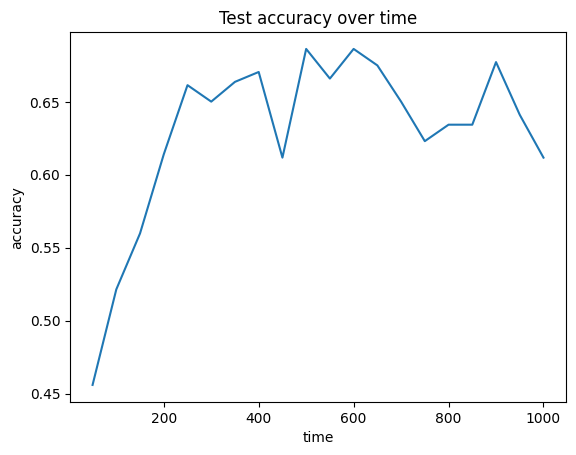

Test Accuracies:
[0.45598194003105164, 0.5214446783065796, 0.5598194003105164, 0.6139954924583435, 0.6613995432853699, 0.6501128673553467, 0.6636568903923035, 0.6704288721084595, 0.6117381453514099, 0.6862302422523499, 0.6659142374992371, 0.6862302422523499, 0.6749435663223267, 0.6501128673553467, 0.6230248212814331, 0.6343114972114563, 0.6343114972114563, 0.6772009134292603, 0.6410835385322571, 0.6117381453514099]
Best test score: 0.6862302422523499
Best time: 500


In [ ]:
# TESTING PARAMETERS
# kernel: 3,3 pool: 2,1, act: relu, dropout: 0.2 <- bad, relu, small dropout kernel and pool cause overfitting
# DROPOUT: 0.7 <-
filters_list = [25, 50, 100, 200]
kernel_size = (8,8)
pool_size = (3,1)
activation = 'elu'
dropout_rate = 0.5
learning_rate = 1e-3
epochs = 100
batch_size = 64

trainovertime()